In [3]:
import struct
import wave
import datetime
import os
import glob
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
from datetime import datetime as dt

In [4]:
PACKET_SIZE = 4
ID_SIZE = 4
TIMESTAMP_SIZE = 8
AUDIO_SAMPLING_FREQ = 16384
AUDIO_SAMPLE_SIZE = 3
AUDIO_SIZE = AUDIO_SAMPLE_SIZE * AUDIO_SAMPLING_FREQ
BME280_SIZE = 4 * 4
MECHANICAL_SIZE = 3 * 4

In [5]:
CHECKSUM = True # checksum has been implemented from 2023-08-09 at 15:00
SAMPLE_SIZE = PACKET_SIZE + ID_SIZE + TIMESTAMP_SIZE + AUDIO_SIZE + BME280_SIZE + MECHANICAL_SIZE
if CHECKSUM:
    SAMPLE_SIZE+=1

In [6]:
# Define paths for saving data
save_in_directory = "./final_dataset2"
os.makedirs(save_in_directory, exist_ok=True)
csv_filename = f"{save_in_directory}/weather_data_with_audio.csv"

In [7]:
# Function to save audio data as .wav
def save_audio(audio_data, file_name, channels=1, sampwidth=AUDIO_SAMPLE_SIZE, framerate=AUDIO_SAMPLING_FREQ):
    obj = wave.open(file_name, "w")
    obj.setnchannels(channels)  # Mono
    obj.setsampwidth(sampwidth)  # Width in bytes
    obj.setframerate(framerate)
    obj.writeframes(audio_data)
    obj.close()

In [8]:
"""
*  \brief     calibration.py
*  \details   Python script to get wind direction from raw data
*  \author    Mateo Haro
*  \version   1.1
*  \date      2022-08-21
*  \pre       None
*  \copyright (c) 2022 CSEM
*
*   CSEM S.A.
*   Jaquet-Droz 1
*   CH-2000 Neuchâtel
*   http://www.csem.ch
*
*
*   THIS PROGRAM IS CONFIDENTIAL AND CANNOT BE DISTRIBUTED
*   WITHOUT THE CSEM PRIOR WRITTEN AGREEMENT.
*
*   CSEM is the owner of this source code and is authorised to use, to modify
*   and to keep confidential all new modifications of this code.
*
"""

WMK_NUM_ANGLES = 16
SFE_WIND_VANE_DEGREES_PER_INDEX = 360/WMK_NUM_ANGLES

class Station:
   def __init__(self, id, calibration):
      self.id = id
      self.vaneADCValues = calibration

   def getWindDirection(self, rawADC):
      """
      We'll loop through all possible directions to find which is closest
      to our measurement, using a simple linear search. closestDifference is
      initialized to max 16-bit signed value (2^15 - 1 = 32,767)
      """
      closestDifference = 32767
      closestIndex = 0

      for i in range(WMK_NUM_ANGLES):
         # Compute the difference between the ADC value for this direction and what we measured
         adcDifference = self.vaneADCValues[i] - rawADC

         # We only care about the magnitude of the difference
         adcDifference = abs(adcDifference)

         # Check if this different is less than our closest so far
         if adcDifference < closestDifference:
            # This resistance is closer, update closest resistance and index
            closestDifference = adcDifference
            closestIndex = i

      # Now compute the wind direction in degrees
      direction = closestIndex * SFE_WIND_VANE_DEGREES_PER_INDEX

      # Return direction in degrees
      # As an indication: 0deg is North and 90deg is East
      return direction

# calibration for mechanical station associated to CSEMAurora1
calibration1 = [2955, 1437, 1658, 172, 208, 105, 568, 336, 965, 797, 2320, 2205, 3876, 3154, 3477, 2609]
station1 = Station(1, calibration1)

# calibration for mechanical station associated to CSEMAurora2
calibration2 = [3050, 1490, 1720, 185, 225, 113, 594, 355, 1007, 831, 2405, 2282, 3930, 3240, 3550, 2700]
station2 = Station(2, calibration2)

# calibration for mechanical station associated to CSEMAurora3
calibration3 = [3012, 1481, 1703, 202, 240, 131, 602, 370, 1008, 835, 2381, 2256, 3865, 3201, 3500, 2670]
station3 = Station(3, calibration2)

# calibration for mechanical station associated to CSEMAurora4
calibration4 = [3018, 1472, 1702, 185, 222, 112, 590, 351, 993, 821, 2375, 2256, 3935, 3217, 3543, 2672]
station3 = Station(4, calibration2)

# calibration for mechanical station associated to CSEMAurora5
calibration5 = [2927, 1423, 1642, 158, 192, 86, 555, 321, 945, 778, 2300, 2181, 3822, 3119, 3434, 2587]
station3 = Station(5, calibration2)


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bruno\AppData\Local\Temp\ipykernel_33836\1088622479.py:1: SyntaxWarning: invalid escape sequence '\d'
  """


In [9]:
#limites para os labels
#Chuva fraca: menos de 1 mm/h.
#Chuva moderada: de 2,5 até 10 mm/h.
#Chuva forte: a partir de 10mm
rain_limits = [0.5, 2, 4] #mm/hr

In [10]:
from datetime import datetime as dt
# Function to convert filename to datetime object for sorting
def filename_to_datetime(filename):
    match = re.search(r'(\d{4}-\d{2}-\d{2})_(\d+)', filename)
    if match:
        date_str, hour_str = match.groups()
        return dt.strptime(f'{date_str} {hour_str}', '%Y-%m-%d %H')
    else:
        return dt.min  # return minimum datetime if no match



In [11]:


#example multiple files
def read_data_multiple_files(directory, save_in_directory):
    count = 0
    total_temperature = 0
    total_pressure = 0
    total_altitude = 0
    total_humidity = 0
    total_wind_count = 0
    total_rain_count = 0
    total_wind_direction = 0
    #sound_data = []
    # Create directory if it doesn't exist
    os.makedirs(save_in_directory, exist_ok=True)

    # Setup for CSV file
    csv_filename = os.path.join(save_in_directory, 'weather_data_with_audio.csv')
    csv_headers = ['timestamp', 'temperature', 'pressure', 'altitude', 'humidity', 'wind_count', 'wind_km_h','rain_count', 'rain_mm', 'wind_direction', 'audio_file', 'label']

    # We will check if the CSV already exists to decide whether to write headers or not
    write_headers = not os.path.exists(csv_filename)

    with open(csv_filename, 'a', newline='') as csv_file:
        csv_writer = csv.DictWriter(csv_file, fieldnames=csv_headers)
        if write_headers:
            csv_writer.writeheader()

        # Get a list of all .dat files in the directory
        dat_files = glob.glob(os.path.join(directory, '*.dat'))

        # Sort the files by filename
        dat_files.sort(key=filename_to_datetime)

        for file_name in dat_files:
            try: 
                print(f"Processing {file_name}...")
                # open the .dat file with "rb" (read binary) mode
                with open(file_name, "rb") as f:
                    data = f.read()
                    f.close()


                # read the binary data
                num_sample = int(len(data) / SAMPLE_SIZE) # should be an integer
                for j in range(num_sample):
                    index = j * SAMPLE_SIZE
                    packet_size = struct.unpack("<L", data[index: index + PACKET_SIZE])[0] # should be equal to SAMPLE_SIZE
                    index += PACKET_SIZE
                    packet_id = struct.unpack("<L", data[index: index + ID_SIZE])[0]
                    index += ID_SIZE
                    timestamp = struct.unpack("<Q", data[index: index + TIMESTAMP_SIZE])[0]
                    index += TIMESTAMP_SIZE
                    samples_raw =  data[index: index + AUDIO_SIZE]
                    index += AUDIO_SIZE
                    bme_values = list(struct.iter_unpack("<f", data[index: index + BME280_SIZE]))
                    index += BME280_SIZE
                    mechanical_values = list(struct.iter_unpack("<I", data[index: index + MECHANICAL_SIZE]))
                    index += MECHANICAL_SIZE

                    # post process and save the BME and mechanical data in a dict
                    BME_data = {"temperature":bme_values[0][0], "pressure":bme_values[1][0], "altitude":bme_values[2][0], "humidity":bme_values[3][0]}
                    mechanical_data = {"wind_count":mechanical_values[0][0],"rain_count":mechanical_values[1][0],"wind_direction":mechanical_values[2][0]}

                    # post process the audio samples collected with I2S protocol
                    # samples = []
                    # for i in range(0, int(AUDIO_SIZE / AUDIO_SAMPLE_SIZE)): # get the number of audio samples, not the number of bytes
                    #     value =     samples_raw[AUDIO_SAMPLE_SIZE*i      ] << 16
                    #     value +=    samples_raw[AUDIO_SAMPLE_SIZE*i + 1  ] << 8
                    #     value +=    samples_raw[AUDIO_SAMPLE_SIZE*i + 2  ]
                    #     if(value>2**23 - 1):
                    #         value = -(2**24 - value)
                    #     samples.append(value)

                    # sound_data += samples

                    count += 1

                    if count == 1:
                        time_ini = datetime.datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
                        time_ini_name = time_ini.replace(':', '_')

                    total_temperature += BME_data['temperature']
                    total_pressure += BME_data['pressure']
                    total_altitude += BME_data['altitude']
                    total_humidity += BME_data['humidity']
                    total_wind_count += mechanical_data['wind_count']
                    total_rain_count += mechanical_data['rain_count']
                    total_wind_direction += mechanical_data['wind_direction']


                    if count == 3600:
                        med_temperature = total_temperature / 3600
                        med_pressure = total_pressure / 3600
                        med_altitude = total_altitude / 3600
                        med_humidity = total_humidity / 3600
                        med_wind_count = total_wind_count / 3600
                        med_wind_direction = total_wind_direction / 3600
                        wind_km_h = med_wind_count * 2.4
                        rain_mm = total_rain_count * 0.2794
                        wind_deg = station1.getWindDirection(med_wind_direction)
                        label = ''
                        if rain_mm < rain_limits[0]:
                            label = 0
                        elif rain_mm < rain_limits[1]:
                            label = 1
                        elif rain_mm < rain_limits[2]:
                            label = 2
                        else:
                            label = 3

                        time_fim = datetime.datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')
                        time_fim_name = time_fim.replace(':', '_')
                        timestamp_name = f"{time_ini_name}_{time_fim_name}"
                        # save sound data in a .wav file
                        # sound_file = f"{save_in_directory}/{timestamp_name}.wav"
                        # obj = wave.open(sound_file, "w")
                        # obj.setnchannels(1)
                        # obj.setsampwidth(AUDIO_SAMPLE_SIZE)
                        # obj.setframerate(AUDIO_SAMPLING_FREQ)
                        # data_as_bytes = [struct.pack("<i", sample) for sample in sound_data] # store it as 4 bytes in LSB format (little endian)
                        # for data_bytes in data_as_bytes:
                        #     obj.writeframes(data_bytes[0:3]) # remove the fourth unused byte one ().
                        # obj.close()

                        row_data = {
                            'timestamp': timestamp_name,
                            'temperature': med_temperature,
                            'pressure': med_pressure,
                            'altitude': med_altitude,
                            'humidity': med_humidity,
                            'wind_count': med_wind_count,
                            'wind_km_h': wind_km_h,
                            'rain_count': total_rain_count,
                            'rain_mm': rain_mm,
                            'wind_direction': wind_deg,
                            'audio_file': 'null',
                            'label': label,
                        }
                        csv_writer.writerow(row_data)

                        total_temperature = 0
                        total_pressure = 0
                        total_altitude = 0
                        total_humidity = 0
                        total_wind_count = 0
                        total_rain_count = 0
                        total_wind_direction = 0
                        count = 0
                        #sound_data = []
                        time_ini = ''
                        time_ini_name =''
            except:
                print(f"Error processing {file_name}...")


In [12]:
# Example usage
directory = './Dados/data'
read_data_multiple_files(directory, save_in_directory)

# Alterando a o método de construçao do csv (teste)

## Ao invés de pegar 3600 amostras, pegar as amostras existentes entre cada intervalo de hora e fazer a média baseada nesse numero

In [13]:

#example multiple files
def read_data_multiple_files_hour(directory, save_in_directory,csv_filename):
    total_temperature = 0
    total_pressure = 0
    total_altitude = 0
    total_humidity = 0
    total_wind_count = 0
    total_rain_count = 0
    total_wind_direction = 0
    contagemAmostras = 0
    #sound_data = []
    # Create directory if it doesn't exist
    os.makedirs(save_in_directory, exist_ok=True)

    # Setup for CSV file
    csv_headers = ['timestamp', 'temperature', 'pressure', 'altitude', 'humidity', 'wind_count', 'wind_km_h','rain_count', 'rain_mm', 'wind_direction', 'audio_file', 'label', 'amostras']

    # We will check if the CSV already exists to decide whether to write headers or not
    write_headers = not os.path.exists(csv_filename)

    with open(csv_filename, 'a', newline='') as csv_file:
        csv_writer = csv.DictWriter(csv_file, fieldnames=csv_headers)
        if write_headers:
            csv_writer.writeheader()

        # Get a list of all .dat files in the directory
        dat_files = glob.glob(os.path.join(directory, '*.dat'))

        # Sort the files by filename
        dat_files.sort(key=filename_to_datetime)

        for file_name in dat_files:
            try: 
                print(f"Processing {file_name}...")
                # open the .dat file with "rb" (read binary) mode
                with open(file_name, "rb") as f:
                    data = f.read()
                    f.close()
                
                #o timestamp deve dever o nome do arquivo raw_data_CSEMAurora1_2023-08-28_0 alterado para o formato 2023-08-27 00_00_00
                timestamp_name = file_name.split('_')[3] + ' ' + file_name.split('_')[4][:-4] + '_' + '00' + '_' + '00'

                # read the binary data
                num_sample = int(len(data) / SAMPLE_SIZE) # should be an integer
                for j in range(num_sample):
                    index = j * SAMPLE_SIZE
                    packet_size = struct.unpack("<L", data[index: index + PACKET_SIZE])[0] # should be equal to SAMPLE_SIZE
                    index += PACKET_SIZE
                    packet_id = struct.unpack("<L", data[index: index + ID_SIZE])[0]
                    index += ID_SIZE
                    timestamp = struct.unpack("<Q", data[index: index + TIMESTAMP_SIZE])[0]
                    index += TIMESTAMP_SIZE
                    samples_raw =  data[index: index + AUDIO_SIZE]
                    index += AUDIO_SIZE
                    bme_values = list(struct.iter_unpack("<f", data[index: index + BME280_SIZE]))
                    index += BME280_SIZE
                    mechanical_values = list(struct.iter_unpack("<I", data[index: index + MECHANICAL_SIZE]))
                    index += MECHANICAL_SIZE

                    # post process and save the BME and mechanical data in a dict
                    BME_data = {"temperature":bme_values[0][0], "pressure":bme_values[1][0], "altitude":bme_values[2][0], "humidity":bme_values[3][0]}
                    mechanical_data = {"wind_count":mechanical_values[0][0],"rain_count":mechanical_values[1][0],"wind_direction":mechanical_values[2][0]}

                    # post process the audio samples collected with I2S protocol
                    # samples = []
                    # for i in range(0, int(AUDIO_SIZE / AUDIO_SAMPLE_SIZE)): # get the number of audio samples, not the number of bytes
                    #     value =     samples_raw[AUDIO_SAMPLE_SIZE*i      ] << 16
                    #     value +=    samples_raw[AUDIO_SAMPLE_SIZE*i + 1  ] << 8
                    #     value +=    samples_raw[AUDIO_SAMPLE_SIZE*i + 2  ]
                    #     if(value>2**23 - 1):
                    #         value = -(2**24 - value)
                    #     samples.append(value)

                    # sound_data += samples


                    total_temperature += BME_data['temperature']
                    total_pressure += BME_data['pressure']
                    total_altitude += BME_data['altitude']
                    total_humidity += BME_data['humidity']
                    total_wind_count += mechanical_data['wind_count']
                    total_rain_count += mechanical_data['rain_count']
                    total_wind_direction += mechanical_data['wind_direction']
                    contagemAmostras += 1


                    
                med_temperature = total_temperature / contagemAmostras
                med_pressure = total_pressure / contagemAmostras
                med_altitude = total_altitude / contagemAmostras
                med_humidity = total_humidity / contagemAmostras
                med_wind_count = total_wind_count / contagemAmostras
                med_wind_direction = total_wind_direction / contagemAmostras
                wind_km_h = med_wind_count * 2.4
                rain_mm = total_rain_count * 0.2794
                wind_deg = station1.getWindDirection(med_wind_direction)
                label = ''
                if rain_mm < rain_limits[0]:
                    label = 0
                elif rain_mm < rain_limits[1]:
                    label = 1
                elif rain_mm < rain_limits[2]:
                    label = 2
                else:
                    label = 3

                row_data = {
                    'timestamp': timestamp_name,
                    'temperature': med_temperature,
                    'pressure': med_pressure,
                    'altitude': med_altitude,
                    'humidity': med_humidity,
                    'wind_count': med_wind_count,
                    'wind_km_h': wind_km_h,
                    'rain_count': total_rain_count,
                    'rain_mm': rain_mm,
                    'wind_direction': wind_deg,
                    'audio_file': 'null',
                    'label': label,
                    'amostras': contagemAmostras,
                }
                csv_writer.writerow(row_data)

                total_temperature = 0
                total_pressure = 0
                total_altitude = 0
                total_humidity = 0
                total_wind_count = 0
                total_rain_count = 0
                total_wind_direction = 0
                contagemAmostras = 0
                #sound_data = []
                time_ini = ''
                time_ini_name =''
            except:
                
                print(f"Error processing {file_name}...")


# Plots

In [14]:
df = pd.read_csv('./final_dataset2/weather_data_with_audio.csv')
df.shape

(2070, 12)

In [15]:
#eliminar a segunda data da coluna timestamp para cada linha e converter para datetime
df['timestamp'] = df['timestamp'].apply(lambda x: x.split('_')[0])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)


In [16]:
print(df)

                     temperature      pressure    altitude   humidity  \
timestamp                                                               
2023-08-27 21:00:00    15.404408  96201.013236  435.617474  77.519944   
2023-08-27 23:00:00    15.351739  96101.163581  444.290949  76.563875   
2023-08-28 00:00:00    15.775292  96042.122897  449.423204  73.046813   
2023-08-28 01:00:00    15.851292  95952.153459  457.248410  62.030141   
2023-08-28 02:00:00    15.734589  95915.147418  460.469193  63.236381   
...                          ...           ...         ...        ...   
2024-02-18 17:00:00    12.337342  97634.069362  311.929143  56.108844   
2024-02-18 18:00:00    11.586031  97675.336213  308.389368  55.650771   
2024-02-18 19:00:00    10.477289  97739.755907  302.865507  70.237237   
2024-02-18 20:00:00     9.304150  97783.056855  299.154599  77.869222   
2024-02-18 21:00:00     9.226642  97776.292930  299.734970  80.772920   

                     wind_count  wind_km_h  rain_c

In [17]:
city = 'Neuchatel, Suiza'
df2 = pd.read_csv('weather_data_Neuchatel_hourly.csv')
df2.shape
df2['date_time'] = pd.to_datetime(df2['date_time'])
df2.set_index('date_time', inplace=True)

#eliminar todos os dados antes de 2023-08-28 00:00 e 2024-02-18 23:00
df2 = df2.loc['2023-08-28 00:00':'2024-02-18 23:00']

#eliminar dados entre 2023-10-09 00:00 e 2023-11-09 00:00
df2 = df2.drop(df2.loc['2023-10-09 00:00':'2023-11-09 00:00'].index)

#eliminar dados entre 2023-11-12 23:00 e 2023-11-24 16:00  
df2 = df2.drop(df2.loc['2023-11-12 23:00':'2023-11-24 16:00'].index)

#eliminar dados entre 2023-11-26 23:00 e 2023-12-07 00:00
df2 = df2.drop(df2.loc['2023-11-26 23:00':'2023-12-07 00:00'].index)

df3 = pd.read_csv('./TestDataset/weather_data_with_audio_hour.csv')
#eliminar a segunda data da coluna timestamp para cada linha e converter para datetime
df3['timestamp'] = pd.to_datetime(df3['timestamp'],format='%Y-%m-%d %H_%M_%S')
df3.set_index('timestamp', inplace=True)




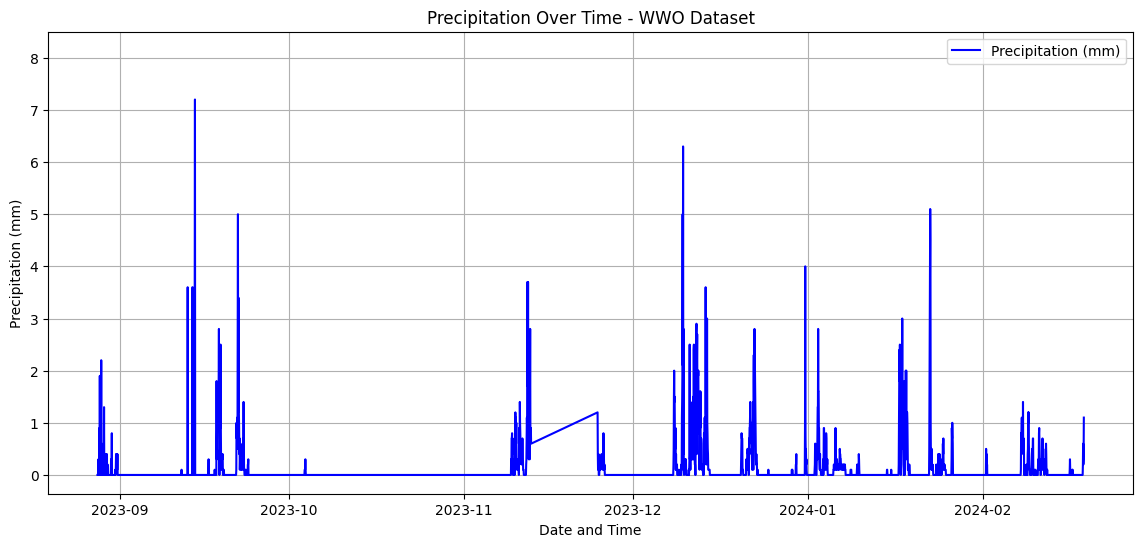

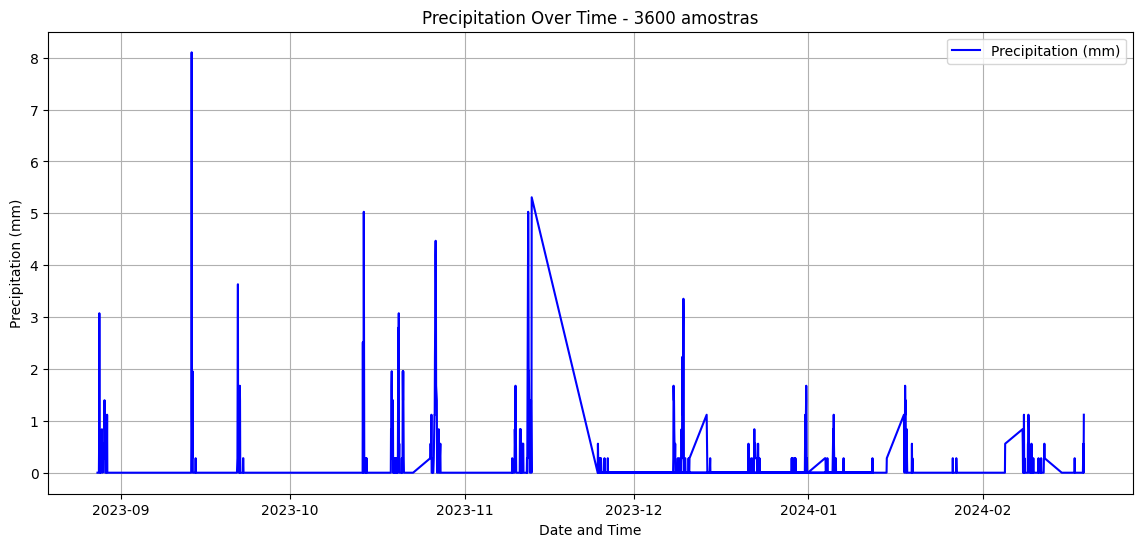

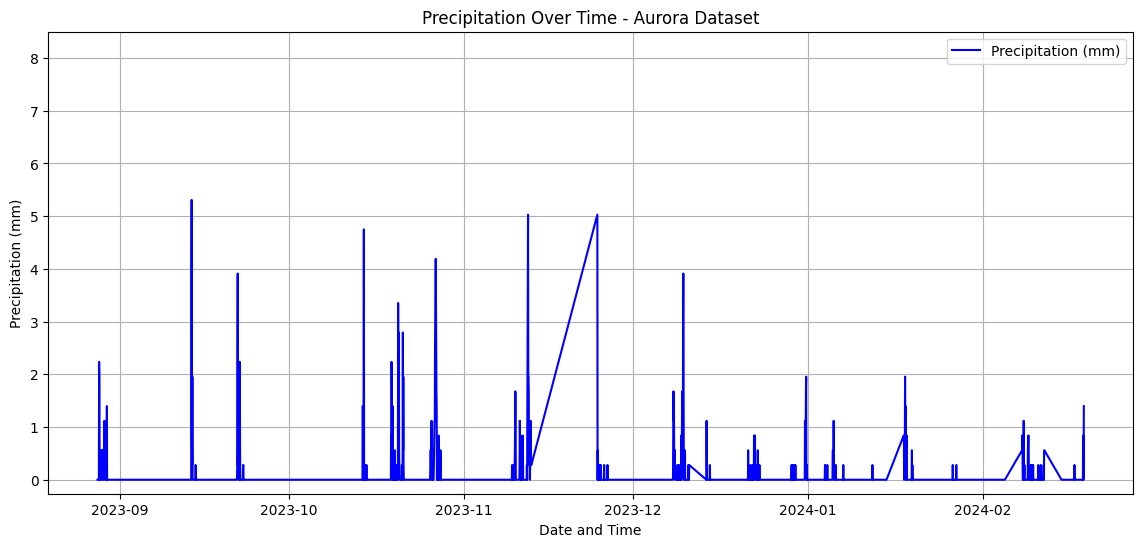

: 

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(df2['precipMM'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation Over Time - WWO Dataset')
plt.xlabel('Date and Time')
plt.ylabel('Precipitation (mm)')
plt.ylim(top=8.5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(df3['rain_mm'], label='Precipitation (mm)', color='blue')
plt.title('Precipitation Over Time - Aurora Dataset')
plt.xlabel('Date and Time')
plt.ylabel('Precipitation (mm)')
plt.ylim(top=8.5)
plt.grid(True)
plt.legend()
plt.show()

# teste

In [6]:
df = pd.read_csv('./final_dataset2/weather_data_with_audio_hour.csv') 
# #mudar a clouna do csv para ficar no formato 2023-08-28_0, onde o ultimo numero é a hora
# df['timestamp'] = df['timestamp'].apply(lambda x: x.split('_')[0])
# #subtituir espaço vaizo por _
# df['timestamp'] = df['timestamp'].apply(lambda x: x.replace(' ', '_'))
# df.head()
# #salvar esse df em um csv
# df.to_csv('./final_dataset2/weather_data_with_audio_hour.csv', index=False)

# #contar quantas linhas tem para cada label
# df['label'].value_counts()
df['timestamp'].values

array(['2023-08-28_0', '2023-08-28_1', '2023-08-28_2', ...,
       '2024-02-18_21', '2024-02-18_22', '2024-02-18_23'], dtype=object)

In [7]:

#example multiple files
def save_audio_data_multiple_files_hour(directory, save_in_directory):

    countLowRain = 1
    countNoRain = 1
    countMediumRain = 1
    countHighRain = 1
    sound_data = []
    label_name = ''
    
    # Create directory if it doesn't exist
    os.makedirs(save_in_directory, exist_ok=True)

    #create directories for each label
    os.makedirs(f"{save_in_directory}/NoRain", exist_ok=True)
    os.makedirs(f"{save_in_directory}/LowRain", exist_ok=True)
    os.makedirs(f"{save_in_directory}/MediumRain", exist_ok=True)
    os.makedirs(f"{save_in_directory}/HighRain", exist_ok=True)

    # Get a list of all .dat files in the directory
    dat_files = glob.glob(os.path.join(directory, '*.dat'))

    # Sort the files by filename
    dat_files.sort(key=filename_to_datetime)
   
    for file_name in dat_files:
        #try: 
            print(f"Processing {file_name}...")         
            
            #o timestamp deve dever o nome do arquivo raw_data_CSEMAurora1_2023-08-28_0 alterado para o formato 2023-08-27 00_00_00
            #ele será comparado com o a coluna timestamp do csv, dependendo do label, o arquivo de audio será salvo em uma pasta específica
            timestamp_name = file_name.split('_')[3] + '_' + file_name.split('_')[4][:-4]
            print(timestamp_name)
            if timestamp_name in df['timestamp'].values:
                print(f"Processing {timestamp_name}...")
                label = df.loc[df['timestamp'] == timestamp_name, 'label'].values[0]
                print(f"Label: {label}")

            #if the four counts are zero, break the loop
            if countNoRain == 0 and countLowRain == 0 and countMediumRain == 0 and countHighRain == 0:
                break

            match label:
                case 0:
                    if countNoRain == 0:
                        continue
                    countNoRain -= 1
                    label_name = 'NoRain'
                case 1:
                    if countLowRain == 0:
                        continue
                    countLowRain -= 1
                    label_name = 'LowRain'
                case 2:
                    if countMediumRain == 0:
                        continue
                    countMediumRain -= 1
                    label_name = 'MediumRain'
                case 3:
                    if countHighRain == 0:
                        continue
                    countHighRain -= 1
                    label_name = 'HighRain'
            
            # open the .dat file with "rb" (read binary) mode
            with open(file_name, "rb") as f:
                data = f.read()
                f.close()            

            # read the binary data
            sound_data = []
            num_sample = int(len(data) / SAMPLE_SIZE) # should be an integer
            for j in range(num_sample):
                index = j * SAMPLE_SIZE
                index += PACKET_SIZE
                # packet_id = struct.unpack("<L", data[index: index + ID_SIZE])[0]
                index += ID_SIZE
                # timestamp = struct.unpack("<Q", data[index: index + TIMESTAMP_SIZE])[0]
                index += TIMESTAMP_SIZE
                samples_raw =  data[index: index + AUDIO_SIZE]
                index += AUDIO_SIZE
                index += BME280_SIZE
                index += MECHANICAL_SIZE

                # post process the audio samples collected with I2S protocol
                samples = []
                for i in range(0, int(AUDIO_SIZE / AUDIO_SAMPLE_SIZE)): # get the number of audio samples, not the number of bytes
                    value =     samples_raw[AUDIO_SAMPLE_SIZE*i      ] << 16
                    value +=    samples_raw[AUDIO_SAMPLE_SIZE*i + 1  ] << 8
                    value +=    samples_raw[AUDIO_SAMPLE_SIZE*i + 2  ]
                    if(value>2**23 - 1):
                        value = -(2**24 - value)
                    samples.append(value)        
                sound_data += samples
               
                            
            #save sound data in a .wav file
            sound_file = f"{save_in_directory}/{label_name}/{timestamp_name}.wav"
            obj = wave.open(sound_file, "w")
            obj.setnchannels(1)
            obj.setsampwidth(AUDIO_SAMPLE_SIZE)
            obj.setframerate(AUDIO_SAMPLING_FREQ)
            data_as_bytes = [struct.pack("<i", sample) for sample in sound_data] # store it as 4 bytes in LSB format (little endian)
            for data_bytes in data_as_bytes:
                obj.writeframes(data_bytes[0:3]) # remove the fourth unused byte one ().
            obj.close()
            
                
        # except:           
        #     print(f"Error processing {file_name}...")


In [8]:
#executar a função
directory = './Dados/data'
save_in_directory = './testeAudios'
save_audio_data_multiple_files_hour(directory, save_in_directory)

Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_0.dat...
2023-08-28_0
Processing 2023-08-28_0...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_1.dat...
2023-08-28_1
Processing 2023-08-28_1...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_2.dat...
2023-08-28_2
Processing 2023-08-28_2...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_3.dat...
2023-08-28_3
Processing 2023-08-28_3...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_4.dat...
2023-08-28_4
Processing 2023-08-28_4...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_5.dat...
2023-08-28_5
Processing 2023-08-28_5...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_6.dat...
2023-08-28_6
Processing 2023-08-28_6...
Label: 0
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_7.dat...
2023-08-28_7
Processing 2023-08-28_7...
Label: 2
Processing ./Dados/data\raw_data_CSEMAurora1_2023-08-28_8.dat...
2023-08-28_8
Processing

: 

In [4]:
def split_audio(audio_file, save_in_directory):
    # Create directory if it doesn't exist
    os.makedirs(save_in_directory, exist_ok=True)

    # Open the audio file
    obj = wave.open(audio_file, "r")
    num_frames = obj.getnframes()
    frame_rate = obj.getframerate()
    num_channels = obj.getnchannels()
    sample_width = obj.getsampwidth()
    duration = num_frames / frame_rate
    num_chunks = int(duration / 30) # 30 seconds chunks
    print(f"Duration: {duration} seconds")
    print(f"Number of chunks: {num_chunks}")

    # Read the audio data
    audio_data = obj.readframes(num_frames)
    obj.close()

    # Split the audio data into 30 seconds chunks
    for i in range(num_chunks):
        chunk_file = f"{save_in_directory}/{os.path.basename(audio_file).split('.')[0]}_{i}.wav"
        obj = wave.open(chunk_file, "w")
        obj.setnchannels(num_channels)
        obj.setsampwidth(sample_width)
        obj.setframerate(frame_rate)
        start_frame = int(i * 30 * frame_rate * num_channels * sample_width)
        end_frame = int((i + 1) * 30 * frame_rate * num_channels * sample_width)
        obj.writeframes(audio_data[start_frame:end_frame])
        obj.close()

    # Handle the last chunk if there's any leftover
    if duration % 30 != 0:
        chunk_file = f"{save_in_directory}/{os.path.basename(audio_file).split('.')[0]}_{num_chunks}.wav"
        obj = wave.open(chunk_file, "w")
        obj.setnchannels(num_channels)
        obj.setsampwidth(sample_width)
        obj.setframerate(frame_rate)
        start_frame = int(num_chunks * 30 * frame_rate * num_channels * sample_width)
        obj.writeframes(audio_data[start_frame:])
        obj.close()


#executar a função
audio_file = 'testeAudios/test2.wav'
save_in_directory = './testeAudios/label2'
split_audio(audio_file, save_in_directory)




Duration: 3600.0 seconds
Number of chunks: 120
